In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from einops import rearrange, repeat
from torch import einsum


In [3]:
class DynamicPositionBias(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    @staticmethod
    def fetch_module_kwargs(kwargs):
        return {
            'dim': kwargs.get('dpos_dim', 64),
            'depth': kwargs.get('dpos_depth', 2),
            'log_distance': kwargs.get('dpos_log_distance', False),
            'norm': kwargs.get('dpos_norm', False)
        }


    def forward(self, i, j, device, dtype):
        # get the (i x j) matrix of distances
        assert i >= 1 and j >= 1 and i <= j, 'I should be in the range [1, j] and j >= 1'
        seq_arange = torch.arange(i, device = device)
        context_arange = torch.arange(j, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (j-1)
        
        # input to continuous positions MLP
        pos = torch.arange(-i + 1, (j+i), device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')
     
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

In [4]:
DynamicPositionBias(
    heads=8,
    **DynamicPositionBias.fetch_module_kwargs({'dpos_dim':222})
)

DynamicPositionBias(
  (mlp): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=222, bias=True)
      (1): Identity()
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=222, out_features=222, bias=True)
      (1): Identity()
      (2): ReLU()
    )
    (2): Linear(in_features=222, out_features=8, bias=True)
  )
)

In [5]:
pos = DynamicPositionBias(64, heads = 8, depth = 2, log_distance = False)
pos = pos(4,3, device = 'cpu', dtype = torch.float32)
pos.squeeze(-1)

AssertionError: I should be in the range [1, j] and j >= 1

In [ ]:
class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')


class CosineAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        temperature=15.5,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        self.talking_heads = kwargs.get('talking_heads', False)
        self.cache_kv = kwargs.get('cache_kv', False) # whether prev key and values are used 
        

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads:
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))

        self.temperature = torch.nn.Parameter(torch.tensor(temperature), requires_grad=True) if isinstance(temperature, float) else temperature

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

        if self.cache_kv:
            cache_heads = n_heads if not self.shared_kv else 1
            self.cache_vector = torch.nn.Parameter(torch.zeros(1, cache_heads, 1, head_dim), requires_grad=True)
            print(self.cache_vector.shape)
    
    def head_proj(self, dots):
        if not self.talking_heads:
            return dots
        dots = self._head_proj(dots)
        return dots      

    def attend(self, query, key, value, mask, k_mask, pos_fn):
        dots = einsum('bhid,bhjd->bhij', query, key) * self.temperature
        dots = self.head_proj(dots)

        dots += pos_fn(i=dots.shape[-2], j=dots.shape[-1], device=dots.device, dtype=dots.dtype)
        qmask, kmask = ~mask, ~k_mask
        attn_mask = ~(rearrange(qmask, "b n -> b () n ()") * rearrange(kmask, "b n -> b () () n"))
    
        if self.causal: # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)
        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = self.activation(dots)
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)

    def lengths_from_mask(self, x, mask):
        if mask is None:
            return x.shape[-2]
        return (~mask).sum(dim=-1)

    def attach_cache(self, k, v, mask, cache_kv, cache_mask):
        if cache_kv is None:
            return k, v, mask
        
        cache_k, cache_v = cache_kv
        
        cache_k, cache_v = cache_k.to(k.device), cache_v.to(k.device)
        cache_vector = self.cache_vector.to(k.device)
        cache_k, cache_v = cache_k + cache_vector, cache_v + cache_vector
        cache_lens = self.lengths_from_mask(cache_k, cache_mask)
        max_cache_len = cache_lens.max()    
        x_lens = self.lengths_from_mask(k, mask)
        new_lens = x_lens + cache_lens
        max_new_len = new_lens.max()
        # so we want to remove excess padding and only have padding at the end of the sequence
        # otherwise things get weird with the position encoding
        # lets used gather to do this (not sure if there is a faster way)
        # fk ill use a for loop to get the indices
        indices = []
        new_k, new_v = torch.cat([cache_k, k], dim=-2), torch.cat([cache_v, v], dim=-2)
   
        # add zero to last dimension to use to fetch the padding
        B,H,N,D= new_k.shape
        zero_vector = torch.zeros((B,H,1,D), device=new_k.device)
        new_k,new_v = torch.cat([new_k, zero_vector], dim=-2), torch.cat([new_v, zero_vector], dim=-2)
    

        for i in range(new_k.shape[0]):
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i]
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_k.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = new_k.shape[-2] - 1
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        # NOW LETS GATHER
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2,B,H,N,D)
        new_kv = torch.stack([new_k, new_v], dim=0) # avoid double gather
        new_k, new_v = torch.gather(new_kv, dim=-2, index=indices)
       
        # just create the new mask
        new_mask = torch.arange(max_new_len, device=mask.device) >= new_lens[:, None]
        return new_k, new_v, new_mask
       
    
        
        

    def forward(self, x, pos_fn, mask=None, cached_kv=None, cached_mask=None):
        assert pos_fn is not None, 'pls provide a position function'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
        #print(x.shape, mask.shape)

        if mask is None:
            mask = torch.zeros(B, N, device=x.device, dtype=torch.bool)

        q, k, v = self.qkv(x)
        q, k = map(l2norm, (q, k))

        if self.cache_kv:
            k, v, k_mask = self.attach_cache(k, v, mask, cached_kv, cached_mask)
     
        out = self.attend(q, k, v, mask, k_mask, pos_fn)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out if not self.cache_kv else (out, k, v)

In [ ]:
z = torch.randn(2, 1, 8, 256)
v = torch.randn(2, 1, 1, 256)
(v.expand_as(z) + 0).shape
a = nn.Identity(d=2)
a(1)

1

In [7]:
pos_fn = DynamicPositionBias(dim = 64, heads = 8, log_distance = False, depth = 2)
cAttn = CosineAttention(n_feats=256, head_dim=32, n_heads=8, temperature=15.5, cache_kv=True, shared_kv=True, talking_heads=True)
x = torch.randn(3, 128, 256)
cached_kv = torch.randn(1,3,1,92,32).repeat(2,1,1,1,1)
print(cached_kv.shape)
cached_mask = torch.zeros(3, 92, dtype=torch.bool)
cached_mask[0, -3:] = True
print(cached_kv.shape, cached_mask.shape)
cached_kv.masked_fill_(rearrange(cached_mask, 'b n -> () b () n ()'), 0)
mask = torch.zeros(3, 128, dtype=torch.bool)

out = cAttn(x, pos_fn, mask, cached_kv, cached_mask)

NameError: name 'CosineAttention' is not defined

In [8]:
cached_kv[0,0,0,:,0][89]

NameError: name 'cached_kv' is not defined

In [9]:
out[0][0,0,:,0][89]

NameError: name 'out' is not defined

In [10]:
out[-2][0,0,:,1]

NameError: name 'out' is not defined

In [11]:
import torch.nn as nn, torch

class HydraAttention(nn.Module):
    def __init__(self, d_model, output_layer='scale_and_bias'):
        '''
        output_layer: 'scale_and_bias' | 'linear' | 'none'
        '''
        super(HydraAttention, self).__init__()
        self.d_model = d_model
        self.qkv = nn.Linear(d_model, d_model * 3)
        if output_layer == 'scale_and_bias':
            self.scale = nn.Parameter(torch.ones(1, 1, d_model))
            self.bias = nn.Parameter(torch.zeros(1, 1, d_model))
            self.out = lambda x: x * self.scale + self.bias
        elif output_layer == 'linear':
            self.out = nn.Linear(d_model, d_model)
        elif output_layer == 'none':
            self.out = nn.Identity()

    def forward(self, x):
        '''x: (B, T, D)'''
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q / q.norm(dim=-1, keepdim=True)
        k = k / k.norm(dim=-1, keepdim=True)
        kv = (k * v).sum(dim=-2, keepdim=True)
        out = q * kv
        return self.out(out)

In [12]:
HydraAttention(256)(x)

NameError: name 'x' is not defined

In [1]:
%cd ../tedlium

/exp/exp1/acp21rjf/deliberation/speachy/tedlium


In [2]:
import non_iid_dataloader as niiddl, torch

[NeMo W 2023-01-10 12:18:03 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-01-10 12:18:03 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [3]:
import tools

In [4]:
from importlib import reload as rl
rl(niiddl)

<module 'non_iid_dataloader' from '/exp/exp1/acp21rjf/deliberation/speachy/tedlium/non_iid_dataloader.py'>

In [5]:
corpus = tools.load_corpus()

In [6]:
tkn = tools.load_tokenizer('./tokenizers/tokenizer_spe_bpe_v128/tokenizer.model')

In [82]:
dl = niiddl.get_eval_dataloader(
    split = corpus['train'],
    batch_size = 100,
    max_duration = 30,
    concat_samples = False,
    return_speaker=True
)

In [83]:
for i in dl:
    z = i
    break

In [84]:
def create_subbatches_eval(audio, audio_lens, text, speakers, segment_lens): # for loops ):
    max_segment_len = segment_lens.max()
    text = np.array(text)
    speakers = np.array(speakers)

    culm_seglens = segment_lens.cumsum(dim=0)
    cur_positions = culm_seglens - segment_lens
    sub_batches_indices = []

    # first get indices for each sub batch of the "rnn"
    for ix in range(max_segment_len):
        indices = []
        for iz in range(len(segment_lens)):
            pos = cur_positions[iz].item()
            if pos < culm_seglens[iz]:
                indices.append(pos)
                cur_positions[iz] += 1
            else:
                indices.append(-1)
        sub_batches_indices.append(torch.tensor(indices, dtype=torch.long))
    ####
    ### after each forward pass the model will return the cached kvs
    # this gets the indices of the correct kvs for the next forward pass
    non_empty_indices = torch.arange(len(segment_lens), dtype=torch.long)
    prev_non_empty_fetch = []
    for i in range(len(sub_batches_indices)):
        cur = sub_batches_indices[i]
        cur = cur[sub_batches_indices[i-1] != -1] if i > 0 else cur
        non_empty_indices = non_empty_indices[cur != -1]
        prev_non_empty_fetch.append(non_empty_indices.clone())
        non_empty_indices = torch.arange(len(non_empty_indices), dtype=torch.long)
    ####
    sub_batches = []
    for i, ix in enumerate(sub_batches_indices):
        sbi = ix[ix != -1]
        cur_audio, cur_audio_lens, cur_text, cur_speakers = audio[sbi], audio_lens[sbi], text[sbi], speakers[sbi]
        # trim audio and tokens to max length in sub batch
        max_cur_audio_len = cur_audio_lens.max()
        cur_audio = cur_audio[:, :max_cur_audio_len]
        sub_batches.append({
            'audio': cur_audio,
            'audio_lens': cur_audio_lens,
            'text': cur_text.tolist(),
            'speakers': cur_speakers.tolist(),
            'prev_state_indices': prev_non_empty_fetch[i] if i > 0 else None, # for the first sub batch there is no previous state  
        })
        
    return sub_batches

In [85]:
import numpy as np

In [86]:
np.array(z['text'])[[0,2]]

array([['was trying to think how is sync connected to happiness and it occurred to me'],
       ["we like to dance together we like singing together and so if you'll put up with this i would like to"]],
      dtype='<U295')

In [87]:
z['speakers']

[[['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStro

In [88]:
z.keys()

dict_keys(['audio', 'audio_lens', 'text', 'speakers', 'segment_lens'])

In [94]:
sbi = create_subbatches_eval(**z)[-5]['speakers']

In [96]:
["_".join(el[0]) for el in sbi]

['StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'AimeeMullins_1998',
 'AimeeMullins_1998',
 'JohnDoerr_2007']

In [19]:
def create_subbatches(audio, audio_lens, tokens, token_lens, segment_lens): # for loops ):
    max_segment_len = segment_lens.max()

    culm_seglens = segment_lens.cumsum(dim=0)
    cur_positions = culm_seglens - segment_lens
    sub_batches_indices = []

    # first get indices for each sub batch of the "rnn"
    for ix in range(max_segment_len):
        indices = []
        for iz in range(len(segment_lens)):
            pos = cur_positions[iz].item()
            if pos < culm_seglens[iz]:
                indices.append(pos)
                cur_positions[iz] += 1
            else:
                indices.append(-1)
        sub_batches_indices.append(torch.tensor(indices, dtype=torch.long))
    ####
    ### after each forward pass the model will return the cached kvs
    # this gets the indices of the correct kvs for the next forward pass
    non_empty_indices = torch.arange(len(segment_lens), dtype=torch.long)
    prev_non_empty_fetch = []
    for i in range(len(sub_batches_indices)):
        cur = sub_batches_indices[i]
        cur = cur[sub_batches_indices[i-1] != -1] if i > 0 else cur
        non_empty_indices = non_empty_indices[cur != -1]
        prev_non_empty_fetch.append(non_empty_indices.clone())
        non_empty_indices = torch.arange(len(non_empty_indices), dtype=torch.long)
    ####
    sub_batches = []
    for i, ix in enumerate(sub_batches_indices):
        sbi = ix[ix != -1]
        cur_audio, cur_audio_lens, cur_tokens, cur_token_lens = audio[sbi], audio_lens[sbi], tokens[sbi], token_lens[sbi]
        # trim audio and tokens to max length in sub batch
        max_cur_audio_len, max_cur_token_len = cur_audio_lens.max(), cur_token_lens.max()
        cur_audio, cur_tokens = cur_audio[:, :max_cur_audio_len], cur_tokens[:, :max_cur_token_len]
        sub_batches.append({
            'audio': cur_audio,
            'audio_lens': cur_audio_lens,
            'tokens': cur_tokens,
            'token_lens': cur_token_lens,
            'prev_state_indices': prev_non_empty_fetch[i] if i > 0 else None, # for the first sub batch there is no previous state  
        })
        
    return sub_batches

In [273]:
import pickle as pkl
with open('masks_bs3.pkl', 'rb') as f:
    att_m_bs10, pad_m_bs10 = pkl.load(f)
    att_m_bs10, pad_m_bs10 = att_m_bs10.to('cpu'), pad_m_bs10.to('cpu')

In [278]:
att_m_bs10[1]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [274]:
att_m_bs3[0 ]

tensor([[[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]]])

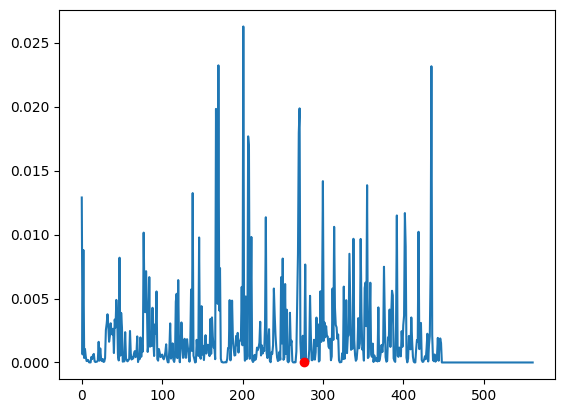

In [262]:
N = 1
B = 2
H = 4
plt.plot(attn[B, H, N, :])
plt.plot(N + (attn.shape[-1]-attn.shape[-2]), 0, 'ro')

In [54]:
def move_to_device(sub_batch, device):
    for k, v in sub_batch.items():
        if isinstance(v, torch.Tensor):
            sub_batch[k] = v.to(device)
    return sub_batch

In [57]:
sb = create_subbatches(**z)

In [58]:
sb[0].keys()

dict_keys(['audio', 'audio_lens', 'tokens', 'token_lens', 'prev_state_indices'])

In [26]:
(1/15)

0.06666666666666667

In [ ]:
torch.nn.ReLU

In [59]:
sb[3]['prev_state_indices']

tensor([ 1,  5,  6, 11])

In [39]:
# init uniform
q = torch.FloatTensor(1, 12, 256).uniform_(-1, 1)
k = torch.FloatTensor(1, 12, 256).uniform_(-1, 1)
dots = torch.einsum('bnd,bmd->bnm', q, k) / q.shape[-1]**0.5
dots.softmax(dim=-1)[0][0]

tensor([0.0861, 0.0966, 0.0760, 0.0431, 0.0482, 0.0565, 0.1114, 0.1451, 0.0998,
        0.0939, 0.0719, 0.0715])

In [100]:
z['metadata'][2]

[{'unique_id': 'f6a3719a-1aa1-48c0-9792-4a28ffd69cb8',
  'timings': {'segment_start': 437.65, 'segment_end': 441.61},
  'recording_id': 'GeverTulley_2007U',
  'utterance_id': 'GeverTulley_2007U-31',
  'speaker': 'GeverTulley_2007U'}]

In [105]:
z.keys()

dict_keys(['audio', 'audio_lens', 'tokens', 'token_lens', 'segment_lens'])

In [106]:
z['audio'].shape

torch.Size([6, 265920])

In [345]:
import torch.nn as nn
from einops import rearrange
class DynamicPositionBiasXL(nn.Module):
    '''Adapted From Phil Wang's x-transformers library
       Altered to work with attention matrix that is not square
    '''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))
        self.history_decay = nn.Parameter(torch.ones(1))
      

    @staticmethod
    def fetch_module_kwargs(kwargs):
        return {
            'dim': kwargs.get('dpos_dim', 64),
            'depth': kwargs.get('dpos_depth', 2),
            'log_distance': kwargs.get('dpos_log_distance', False),
            'norm': kwargs.get('dpos_norm', False)
        }

    def forward(self, i, j, device, dtype):
        # get the (i x j) matrix of distances
        assert i >= 1 and j >= 1 and i <= j, 'I should be in the range [1, j] and j >= 1'
        
        seq_arange = torch.arange(i, device = device)
        context_arange = torch.arange(j, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (j-1)
        
        # input to continuous positions MLP
        pos = torch.arange(-i + 1, (j+i), device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')
     
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)
        
        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')

        if j > i:
            history_len = j - i
            bias[:, :, :history_len] *= self.history_decay

        return bias

In [346]:
dpos = DynamicPositionBiasXL(dim=256, heads=8, depth=2)
pos = dpos(10, 10, 'cpu', torch.float32).squeeze()

In [351]:
test_mask = (torch.randn(10) <0.5)

In [354]:
(test_mask +1).bool()

tensor([True, True, True, True, True, True, True, True, True, True])

In [355]:
r = torch.randn(10) *10

In [360]:
r[r<5] = 10

In [363]:
-1422.823974609375 == -1422.823974609375

True

: 

In [361]:
AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.23945454545454545


AUDIOTOTAL: -1422.8238525390625
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.8238525390625
WER (nemo): 0.2394909090909091




tensor([10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,  8.9258, 17.1805,
        10.0000, 10.0000])

In [ ]:
AUDIOTOTAL: -1422.82373046875
WER (nemo): 0.9292

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.9292363636363636


In [ ]:
0.7781906166848194
0.778211296926916
0.7781837232707871
0.7781492562006259

In [ ]:
0.7781630430286904
0.7781630430286904

In [ ]:
AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.7783146981373995

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.7783146981373995
0.04769553168902431


0.08378181818181818
0.08367272727272727

In [ ]:
AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.09825454545454546

AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.0982909090909091

AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.0982909090909091
